This notebook is being developed as part of the Code Kentucky Python Data Analyst pathway.

---

Goal: Quantify the impact of road closures based on three metrics:
1) Total number of closures<br>
2) Frequency of closures<br>
3) Duration of closures.<br>

These are a few of the sample questions that I hope to answer:<br>
1) How many closures occur statewide each year? (Typical bar graph showing count per year?)<br>
2) How many road closures occur in each county per year? (Normal bar graph with year as x-axis and count of closures?)<br>
3) How often, or how frequently, is a single road being closed due to rainfall? (Horizonatal bar graph with roadname as Y axis or pivot table output?)<br>
4) What is the average duration of road closures?

DISCLAIMER:  Results may vary.  In addition to historic data, this notebook is also utilizing current year data.  The data source is updated every 1 hour but only when there are active road closures due to weather related events.

-Chris Lambert

---

| Field           | Data Type    | Description                                                                                               | Examples                   |
|-----------------|--------------|-----------------------------------------------------------------------------------------------------------|----------------------------|
| District        | Integer      | KYTC divides the state into 12 geographic regions. Districts start from 1 in the West to 12 in the East. | 1, 2, 3, etc.              |
| County          | Object       | The name of the county where the event occurred. County names are proper case.                            | Fayette, Frankfort, etc.  |
| Route           | Object       | The route name associated with the incident.                                                             | KY-80, US-60, I-69        |
| Road_Name       | Object       | The name of the road associated with the transportation records.                                          | DONALDSON CREEK RD, etc. |
| Begin_MP        | Float        | The milepost where the event or condition begins on the road.                                              | 10.5, 20.3, etc.           |
| End_MP          | Float        | The milepost where the event or condition ends on the road.                                                | 15.2, 25.7, etc.           |
| Comments        | Object       | Additional comments or information related to the transportation event.                                   | N/A                        |
| Reported_On     | Datetime     | The date and time when the transportation event was reported. All reports are in Eastern Standard Time.   | YYYY-MM-DD HH:MM:SS       |
| End_Date        | Datetime     | The date and time when the transportation event concluded or was resolved. All reports are in EST.        | YYYY-MM-DD HH:MM:SS       |
| latitude        | Float        | The latitude coordinate associated with the location of the transportation event.                         | 38.1234, 39.5678, etc.    |
| longitude       | Float        | The longitude coordinate associated with the location of the transportation event.                        | -84.5678, -85.1234, etc.  |
| Duration_Default| Timedelta    | The default duration of the transportation event.                                                        | 0 days 01:30:00, etc.     |
| Duration_Hours  | Float        | The duration of the transportation event in hours.                                                        | 1.5, 2.75, etc.            |


In [1]:
#Pandas is used for data manipulation and analysis.
#Matplotlib is used for data visualization.
#os is used to create folders
#urlretrieve is used to download files from the internet

import pandas as pd
import matplotlib.pyplot as plt 
import os
from urllib.request import urlretrieve

#Create folders if it does not exist
os.makedirs('data-raw', exist_ok=True)
os.makedirs('data-clean', exist_ok=True)
os.makedirs('data-reportready', exist_ok=True)
os.makedirs('temp', exist_ok=True)

#Alternative method for retrieving the data.  This allows for discovery of the raw data with other tools.
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2021.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2021.csv')
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2022.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2022.csv')
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2023.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2023.csv')
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2024.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2024.csv')
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2025.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2025.csv')

Import each year into individual dataframes.

---

In [2]:
#Import files directly from the website into memory
df2021=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2021.csv")
df2022=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2022.csv")
df2023=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2023.csv")
df2024=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2024.csv")
df2025=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2025.csv")

#Export the dataset to a csv file as a method of copying the data to the local machine.
df2021.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2021.csv", index=False)
df2022.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2022.csv", index=False)
df2023.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2023.csv", index=False)
df2024.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2024.csv", index=False)
df2025.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2025.csv", index=False)


After reviewing the data, I noticed the following issues:
- 'Route_Link' in 2021 uses an ESRI formatted hyperlink.
- 'Route_Link' 2022+ uses Google Map formatted hyperlink.
- 'Route_Link' in 2023 contained additional characters at the end of the URL
- The latitide and longitude are in different orders, depending on the map provider.
- 'Reported_On' and 'End_Date' columns contain what looks like different timestamps for some of the years.
- 'Comments' contained line breaks that needed to be cleaned.

Functions to Clean Various Data Issues

---

In [3]:
#Function to clean the data.
def clean_tl(df):
    #clening the datetimes in the dataframes
    df['End_Date'] = df['End_Date'].str.replace('+00:00', '')
    df['Reported_On'] = pd.to_datetime(df['Reported_On'])
    df['End_Date'] = pd.to_datetime(df['End_Date'])
    #calculating the duration of the incidents
    df['Duration_Default'] = (df['End_Date']) - (df['Reported_On'])
    #converting the duration to hours to make it easier for reporting software
    df['Duration_Hours'] = (df['Duration_Default'].dt.total_seconds() / 3600).round(4)
    #removing line breaks from the comments column.
    df['Comments'] = df['Comments'].replace(r'[\r\n]+', ' ', regex=True) 
    return df


In [4]:
#Clean the ESRI link (notice the longitude then latitide)
def clean_esri_link(df):
    df['Route_Link'] = df['Route_Link'].str.replace('https://kytc.maps.arcgis.com/apps/webappviewer/index.html?id=327a38decc8c4e5cb882dc6cd0f9d45d&zoom=14&center=', '')
    df[['longitude', 'latitude']] = df['Route_Link'].str.split(",", expand=True)
    df = df.drop('Route_Link', axis=1, inplace=True)
    return df


In [5]:
#Clean the Google Maps link
def clean_google_link(df):
    df['Route_Link'] = df['Route_Link'].str.replace('https://goky.ky.gov/?lat=','')
    df['Route_Link'] = df['Route_Link'].str.replace('&lng=',',')
    df['Route_Link'] = df['Route_Link'].str.replace('&.*', '', regex=True)
    df[['latitude','longitude']] = df.Route_Link.str.split(",",expand=True)
    df = df.drop('Route_Link', axis=1, inplace=True)
    return df


2021 Dataset

---

In [6]:
#Clean the 2021 dataset.

#Calling my function to clean an ESRI map URL.
clean_esri_link(df2021)

#Calling my function to clean the dataframe
clean_tl(df2021)

#Reorder the columns to make it compatible with the 2022+ datasets.
order=['District','County','Route','Road_Name','Begin_MP','End_MP','Comments','Reported_On','End_Date','latitude','longitude','Duration_Default','Duration_Hours']

#Export the clean 2021 dataset to a csv file to show progress.
df2021.to_csv("data-clean/kytc-closures-2021-clean.csv", index=False)

In [7]:
#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2021.dtypes) #verify the datatypes in the dataframe
#print(df2021.head(3)) #print the first 3 rows of the dataframe

2022 Dataset

---

In [8]:
#Clean the 2022 dataset.

#Calling my function to clean a Google map URL.
clean_google_link(df2022)

#calling my function to clean the dataframe
clean_tl(df2022)

#Export the clean 2022 dataset to a csv file to show progress.
df2022.to_csv("data-clean/kytc-closures-2022-clean.csv", index=False)

In [9]:
#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2022.dtypes) #verify the datatypes in the dataframe
#print(df2022.head(3)) #print the first 3 rows of the dataframe

2023 Dataset

---

In [10]:
#Clean the 2023 dataset.

#Calling my function to clean a Google map URL.
clean_google_link(df2023)

#calling my function to clean the dataframe
clean_tl(df2023)

#Export the clean 2023 dataset to a csv file to show progress.
df2023.to_csv("data-clean/kytc-closures-2023-clean.csv", index=False)

In [11]:
#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2023.dtypes) #verify the datatypes in the dataframe
#print(df2023.head(3)) #print the first 3 rows of the dataframe

2024 Dataset

---

In [12]:
#Analyze the 2024 dataset.
#Since this is 2024, this dataset is updated every 1 hour during weather events.
#This will produce different calculations throughout the year.

#Calling my function to clean a Google map URL.
clean_google_link(df2024)

#calling my function to clean the dataframe
clean_tl(df2024)

#Export the clean 2023 dataset to a csv file to show progress.
df2024.to_csv("data-clean/kytc-closures-2024-clean.csv", index=False)

2025 Dataset (year to date)

---

In [13]:
#Analyze the 2025 dataset.
#Since this is 2025, this dataset is updated every 1 hour during weather events.
#This will produce different calculations throughout the year.

#Calling my function to clean a Google map URL.
clean_google_link(df2025)

#calling my function to clean the dataframe
clean_tl(df2025)

#Export the clean 2023 dataset to a csv file to show progress.
df2025.to_csv("data-clean/kytc-closures-2025-clean.csv", index=False)

In [14]:
#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2024.dtypes) #verify the datatypes in the dataframe
#print(df2024.head(3)) #print the first 3 rows of the dataframe

Order and Merge Dataframes<br>
Create Reporting Datasets in Different File Formets<br>
CSV, XLXS, and Parquet are all popular formats among various types of users and use cases.

---

In [15]:
#Merge the following dataframes together.
#In 2021, the columns are in a slightly different order.

#I've developed a column list to force uniformity between the datasets.
col_order=['District','County','Route','Road_Name','Begin_MP','End_MP','Comments','Reported_On','End_Date','latitude','longitude','Duration_Default','Duration_Hours']
df2021=df2021[col_order]
df2022=df2022[col_order]
df2023=df2023[col_order]
df2024=df2024[col_order]
df2025=df2025[col_order]

#One last analysis of the data revealed erroneous time calculations.  I should have caught this earlier.
#There are 6 records that calculate negative duration_hours.  Since these are erroneous, I have removed them.
#While not all data is completely accurate, it is completely possible to see closures lasting 100s of days for repair.
df2021 = df2021[df2021['Duration_Hours'] > 0]
df2022 = df2022[df2022['Duration_Hours'] > 0]
df2023 = df2023[df2023['Duration_Hours'] > 0]
df2024 = df2024[df2024['Duration_Hours'] > 0]
df2025 = df2025[df2025['Duration_Hours'] > 0]

#Merge the dataframes together into a single, cleaned reporting dataset.
df = pd.concat([df2021, df2022, df2023, df2024, df2025])

#Export the final reporting dataset to CSV
#CSV is normally my default export file format since it easy to read and manipulate using simple text editors.
df.to_csv("data-reportready/kytc-closures-2021-2025-report_dataset.csv", index=False) 

#Export the file reporting dataset to XLSX
#XLSX is useful and prefered over CSV by most MS Office users.
#Requires the openpyxl library to be installed with Pandas
df.to_excel("data-reportready/kytc-closures-2021-2025-report_dataset.xlsx", index=False) 

#Parquest is a compressed, columnar storage format, which is good for analytics.
#Parquet is used by many of the modren data platforms.
df.to_parquet("data-reportready/kytc-closures-2021-2025-report_dataset.parquet", index=False) 


Develop Visualizations (matplotlib)<br>
First, verify the data types.

---

In [16]:
#df.info() #Print the dataframe info to the console.  This is useful for debugging and understanding the data.

This first section will deal with counting the number of closures per Year, District, and then County

---

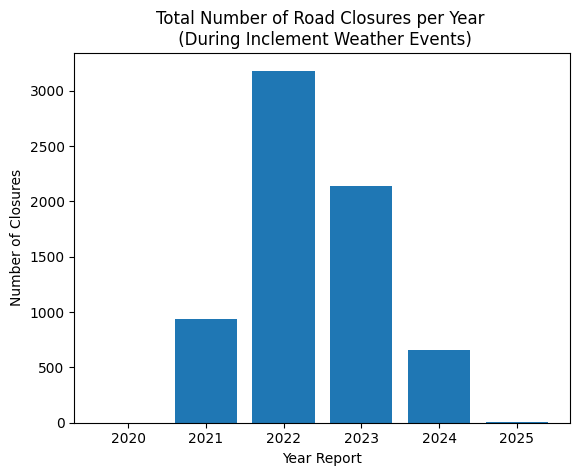

In [17]:
#Extract the year from "Reported_On" value to use on the plot.
df['Year'] = df['Reported_On'].dt.year

#Count the number of closures per year
closure_counts = df['Year'].value_counts()

# Plot the data
plt.bar(closure_counts.index, closure_counts.values)
plt.xlabel('Year Report')
plt.ylabel('Number of Closures')
plt.title('Total Number of Road Closures per Year \n (During Inclement Weather Events)') #ading the \n forces a line break in the title.
plt.show()


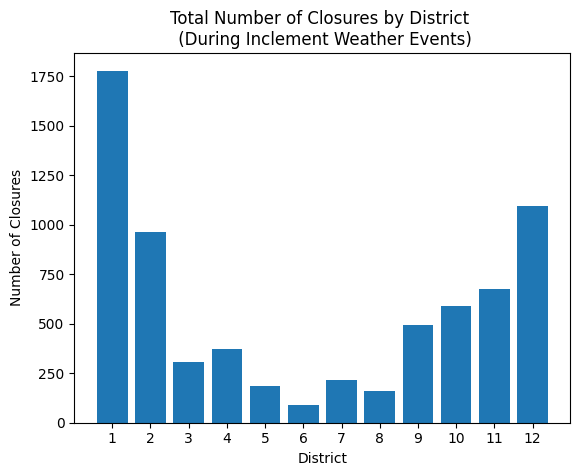

In [18]:
#Calculate the number of closures per district and then plot the data.
closure_counts_by_district = df['District'].value_counts()

# Plot the data
plt.bar(closure_counts_by_district.index, closure_counts_by_district.values)
plt.xlabel('District')
plt.ylabel('Number of Closures')
plt.title('Total Number of Closures by District \n (During Inclement Weather Events)')

# Set the x-axis ticks to show all 12 districts
plt.xticks(closure_counts_by_district.index)

plt.show()


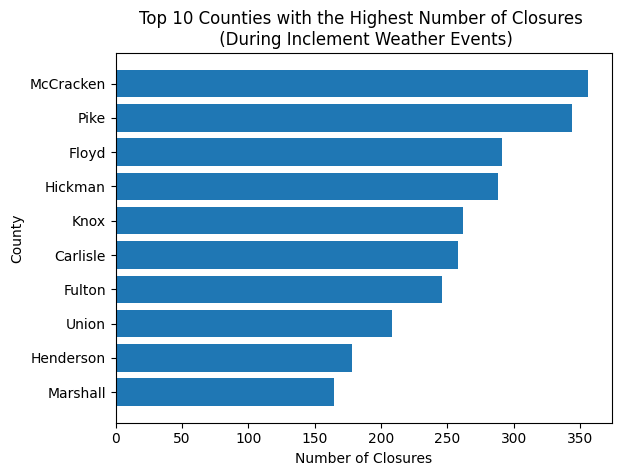

In [19]:
# Calculate the number of closures per County
closure_counts_by_county = df['County'].value_counts()

# Select the top 10 counties
top_10_counties = closure_counts_by_county.head(10) #adjust for more counties if needed.

# Sort the counties by the number of closures in descending order
top_10_counties = top_10_counties.sort_values(ascending=True)

# Plot the data
plt.barh(top_10_counties.index, top_10_counties.values)
plt.xlabel('Number of Closures')
plt.ylabel('County')
plt.title('Top 10 Counties with the Highest Number of Closures \n (During Inclement Weather Events)')

plt.show()


This section will deal with summarizing the duration of closures per year, district, and county.

---

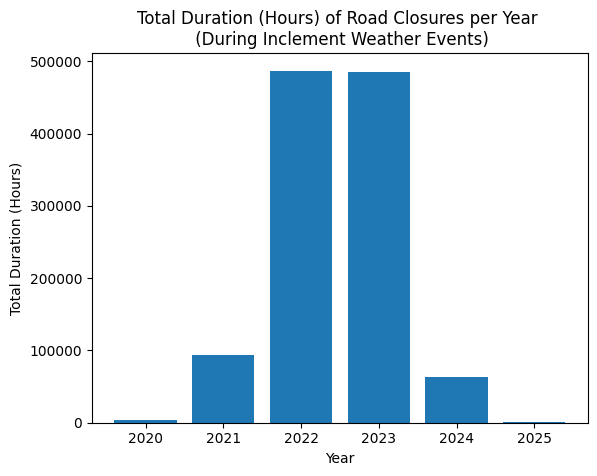

In [20]:
# Total the duration_hours per year
total_duration = df.groupby(df['Reported_On'].dt.year)['Duration_Hours'].sum()

plt.bar(total_duration.index, total_duration.values)

plt.xlabel('Year')
plt.ylabel('Total Duration (Hours)')
plt.title('Total Duration (Hours) of Road Closures per Year \n (During Inclement Weather Events)')
plt.show()



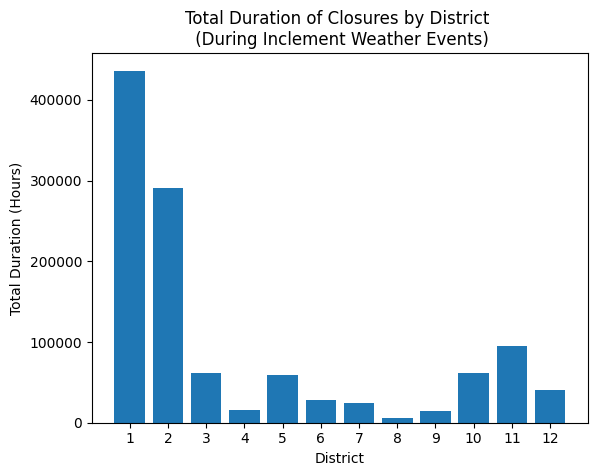

In [21]:
# Calculate the total hours of closures by District and plot the data.
total_duration_by_district = df.groupby('District')['Duration_Hours'].sum()

# Plot the data
plt.bar(total_duration_by_district.index, total_duration_by_district.values)
plt.xlabel('District')
plt.ylabel('Total Duration (Hours)')
plt.title('Total Duration of Closures by District \n (During Inclement Weather Events)')

# Set the x-axis ticks to show all 12 districts
plt.xticks(total_duration_by_district.index)

plt.show()



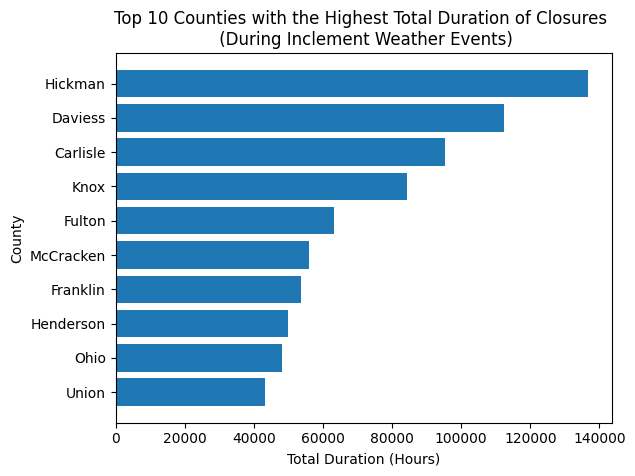

In [22]:
# Calculate the total hours of closures by County
total_duration_by_county = df.groupby('County')['Duration_Hours'].sum()

# Select the top 10 counties
top_10_counties = total_duration_by_county.nlargest(10) #adjust for more counties if needed.

# Sort the counties by the total duration in descending order
top_10_counties = top_10_counties.sort_values(ascending=True)

# Plot the data
plt.barh(top_10_counties.index, top_10_counties.values)
plt.xlabel('Total Duration (Hours)')
plt.ylabel('County')
plt.title('Top 10 Counties with the Highest Total Duration of Closures \n (During Inclement Weather Events)')

plt.show()


Optional Feature: Check for PowerBI file and PDF export in the repo.

---